In [57]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, 
    roc_auc_score, f1_score, precision_score, recall_score,
    roc_curve, auc
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
from datetime import datetime
import json
warnings.filterwarnings('ignore')
# Set professional plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

### DATA LOADING & EXPLORATION

In [64]:
DATA_PATH = '../../data/processed'

# Load preprocessed datasets
X_train = pd.read_csv(f'{DATA_PATH}/step6_X_train.csv')
y_train = pd.read_csv(f'{DATA_PATH}/step6_y_train.csv').squeeze()

X_validate = pd.read_csv(f'{DATA_PATH}/step6_X_val.csv')
y_validate = pd.read_csv(f'{DATA_PATH}/step6_y_val.csv').squeeze()

X_test = pd.read_csv(f'{DATA_PATH}/step6_X_test.csv')
y_test = pd.read_csv(f'{DATA_PATH}/step6_y_test.csv').squeeze()

X_retrain = pd.read_csv(f'{DATA_PATH}/step6_X_new.csv')
y_retrain = pd.read_csv(f'{DATA_PATH}/step6_y_new.csv').squeeze()

print("📊 Dataset Configuration:")
print(f"   Training Set:    {X_train.shape[0]:,} samples × {X_train.shape[1]} features")
print(f"   Validation Set:  {X_validate.shape[0]:,} samples × {X_validate.shape[1]} features")
print(f"   Test Set:        {X_test.shape[0]:,} samples × {X_test.shape[1]} features")
print(f"   Retrain Pool:    {X_retrain.shape[0]:,} samples × {X_retrain.shape[1]} features")
print(f"   Total KOIs:      {X_train.shape[0] + X_validate.shape[0] + X_test.shape[0]:,}\n")

# Verify critical transit features
transit_features = ['koi_duration', 'koi_depth', 'koi_model_snr']
print("🔬 Transit Method Features:")
for feat in transit_features:
    if feat in X_train.columns:
        print(f"   ✓ {feat}")
    else:
        print(f"   ✗ {feat} - WARNING: MISSING!")

print(f"\n🎯 Exoplanet Classification Distribution:")
class_names = {0: 'False Positive', 1: 'Candidate', 2: 'Confirmed Exoplanet'}
print("\n   Training Set:")
for cls, count in y_train.value_counts().sort_index().items():
    pct = (count / len(y_train)) * 100
    print(f"      {class_names[cls]:20s}: {count:5,} ({pct:5.2f}%)")

📊 Dataset Configuration:
   Training Set:    6,694 samples × 13 features
   Validation Set:  956 samples × 13 features
   Test Set:        957 samples × 13 features
   Retrain Pool:    957 samples × 13 features
   Total KOIs:      8,607

🔬 Transit Method Features:
   ✓ koi_duration
   ✓ koi_depth
   ✓ koi_model_snr

🎯 Exoplanet Classification Distribution:

   Training Set:
      False Positive      : 3,387 (50.60%)
      Candidate           : 1,385 (20.69%)
      Confirmed Exoplanet : 1,922 (28.71%)


### TRANSIT PHYSICS FEATURE ENGINEERING

In [65]:
def engineer_transit_features(X):
    """
    Create physics-informed features from transit parameters.
    
    Scientific rationale:
    - Depth/Duration ratio correlates with planet density
    - SNR thresholds separate noise from true signals
    - Combined metrics improve boundary detection
    """
    X_enhanced = X.copy()
    
    # 1. Depth-Duration Interaction (planet density proxy)
    if 'koi_depth' in X.columns and 'koi_duration' in X.columns:
        X_enhanced['transit_depth_duration_ratio'] = (
            X['koi_depth'] / (X['koi_duration'] + 1e-6)
        )
        print("   ✓ Created: transit_depth_duration_ratio (density proxy)")
    
    # 2. Signal Quality Score
    if 'koi_model_snr' in X.columns:
        X_enhanced['snr_log'] = np.log1p(X['koi_model_snr'])
        X_enhanced['snr_squared'] = X['koi_model_snr'] ** 2
        print("   ✓ Created: snr_log, snr_squared (detection confidence)")
    
    # 3. Transit Detectability Index
    if all(f in X.columns for f in transit_features):
        X_enhanced['transit_detectability'] = (
            X['koi_depth'] * X['koi_model_snr'] / (X['koi_duration'] + 1)
        )
        print("   ✓ Created: transit_detectability (combined metric)")
    
    # 4. Normalized transit depth (relative to typical values)
    if 'koi_depth' in X.columns:
        X_enhanced['depth_normalized'] = X['koi_depth'] / X['koi_depth'].median()
        print("   ✓ Created: depth_normalized (relative magnitude)")
    
    return X_enhanced

print("Applying feature engineering to all datasets...\n")
X_train_enhanced = engineer_transit_features(X_train)
X_validate_enhanced = engineer_transit_features(X_validate)
X_test_enhanced = engineer_transit_features(X_test)
X_retrain_enhanced = engineer_transit_features(X_retrain)

print(f"\n📈 Enhanced Feature Space: {X_train_enhanced.shape[1]} features")
print(f"   Added {X_train_enhanced.shape[1] - X_train.shape[1]} transit-derived features")

Applying feature engineering to all datasets...

   ✓ Created: transit_depth_duration_ratio (density proxy)
   ✓ Created: snr_log, snr_squared (detection confidence)
   ✓ Created: transit_detectability (combined metric)
   ✓ Created: depth_normalized (relative magnitude)
   ✓ Created: transit_depth_duration_ratio (density proxy)
   ✓ Created: snr_log, snr_squared (detection confidence)
   ✓ Created: transit_detectability (combined metric)
   ✓ Created: depth_normalized (relative magnitude)
   ✓ Created: transit_depth_duration_ratio (density proxy)
   ✓ Created: snr_log, snr_squared (detection confidence)
   ✓ Created: transit_detectability (combined metric)
   ✓ Created: depth_normalized (relative magnitude)
   ✓ Created: transit_depth_duration_ratio (density proxy)
   ✓ Created: snr_log, snr_squared (detection confidence)
   ✓ Created: transit_detectability (combined metric)
   ✓ Created: depth_normalized (relative magnitude)

📈 Enhanced Feature Space: 18 features
   Added 5 transit-d

### INTELLIGENT CLASS BALANCING

In [66]:
from sklearn.utils.class_weight import compute_class_weight

all_classes = np.array([0, 1, 2])
weights = compute_class_weight(
    class_weight='balanced', 
    classes=all_classes, 
    y=y_train
)
class_weights = dict(zip(all_classes, weights))

print("Computed Sample Weights:")
for cls, weight in class_weights.items():
    print(f"   {class_names[cls]:20s}: {weight:.4f}x")

# Create sample weights for training
sample_weights = np.array([class_weights[cls] for cls in y_train])

Computed Sample Weights:
   False Positive      : 0.6588x
   Candidate           : 1.6111x
   Confirmed Exoplanet : 1.1609x


### LIGHTGBM CONFIGURATION - TRANSIT OPTIMIZED

In [67]:
lgb_params = {
    # Classification setup
    'objective': 'multiclass',
    'num_class': 3,
    'metric': ['multi_logloss', 'multi_error'],
    'boosting_type': 'gbdt',
    
    # Learning dynamics - balanced for stability & performance
    'learning_rate': 0.03,
    'num_leaves': 31,
    'max_depth': 10,
    
    # Tree growth strategy
    'min_data_in_leaf': 30,
    'min_sum_hessian_in_leaf': 0.001,
    
    # Regularization (prevent overfitting on small transit signals)
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    
    # Class imbalance handling
    'is_unbalance': True,
    
    # Performance & reproducibility
    'n_jobs': -1,
    'verbose': -1,
    'random_state': 42,
    'deterministic': True
}

print("🔧 Hyperparameter Configuration:")
print(f"   Learning Rate:     {lgb_params['learning_rate']}")
print(f"   Max Tree Depth:    {lgb_params['max_depth']}")
print(f"   Num Leaves:        {lgb_params['num_leaves']}")
print(f"   Feature Sampling:  {lgb_params['feature_fraction']*100:.0f}%")
print(f"   Data Sampling:     {lgb_params['bagging_fraction']*100:.0f}%")
print(f"   Regularization:    L1={lgb_params['lambda_l1']}, L2={lgb_params['lambda_l2']}")

🔧 Hyperparameter Configuration:
   Learning Rate:     0.03
   Max Tree Depth:    10
   Num Leaves:        31
   Feature Sampling:  80%
   Data Sampling:     80%
   Regularization:    L1=0.1, L2=0.1


### MODEL TRAINING WITH EARLY STOPPING

In [68]:
train_data = lgb.Dataset(
    X_train_enhanced, 
    label=y_train,
    weight=sample_weights,
    free_raw_data=False
)

val_data = lgb.Dataset(
    X_validate_enhanced, 
    label=y_validate,
    reference=train_data,
    free_raw_data=False
)

print("🚀 Initiating gradient boosting training...")
print("   Monitoring: validation loss & error rate")
print("   Early stop: 100 rounds without improvement\n")

# Training with callbacks
callbacks = [
    lgb.early_stopping(stopping_rounds=100, verbose=False),
    lgb.log_evaluation(period=100)
]

model = lgb.train(
    lgb_params,
    train_data,
    num_boost_round=3000,
    valid_sets=[train_data, val_data],
    valid_names=['train', 'valid'],
    callbacks=callbacks
)

print(f"\n✅ Training Complete!")
print(f"   Best Iteration:    {model.best_iteration}")
print(f"   Best Valid Loss:   {model.best_score['valid']['multi_logloss']:.6f}")
print(f"   Best Valid Error:  {model.best_score['valid']['multi_error']:.6f}")

🚀 Initiating gradient boosting training...
   Monitoring: validation loss & error rate
   Early stop: 100 rounds without improvement

[100]	train's multi_logloss: 0.44337	train's multi_error: 0.169322	valid's multi_logloss: 0.511897	valid's multi_error: 0.229079
[200]	train's multi_logloss: 0.329439	train's multi_error: 0.11041	valid's multi_logloss: 0.483321	valid's multi_error: 0.218619
[300]	train's multi_logloss: 0.256166	train's multi_error: 0.0693699	valid's multi_logloss: 0.478652	valid's multi_error: 0.213389

✅ Training Complete!
   Best Iteration:    264
   Best Valid Loss:   0.478095
   Best Valid Error:  0.205021


### FEATURE IMPORTANCE ANALYSIS

In [69]:
feature_importance = pd.DataFrame({
    'feature': X_train_enhanced.columns,
    'importance': model.feature_importance(importance_type='gain'),
    'split_count': model.feature_importance(importance_type='split')
}).sort_values('importance', ascending=False)

print("Top 20 Most Influential Features:\n")
print(feature_importance.head(20).to_string(index=False))

# Highlight transit features
print("\n🔭 Transit Method Feature Rankings:")
for feat in transit_features:
    if feat in feature_importance['feature'].values:
        rank = feature_importance[feature_importance['feature'] == feat].index[0] + 1
        imp = feature_importance[feature_importance['feature'] == feat]['importance'].values[0]
        print(f"   {feat:20s}: Rank #{rank:2d}, Importance: {imp:.2f}")

Top 20 Most Influential Features:

                     feature   importance  split_count
                    koi_prad 21394.304057         1450
               koi_model_snr 21337.948736         1306
           koi_duration_err1 16698.331932         2025
                  koi_period 16208.292397         1944
                 snr_squared 12511.194532          908
               koi_prad_err1 10287.468065         1381
                koi_duration  8611.188641         1688
             koi_period_err1  8508.219395         1514
               koi_srad_err1  8478.371556         1658
                    koi_srad  5894.813819         1597
              koi_depth_err1  5643.511747         1389
               koi_srad_err2  5105.687066         1452
       transit_detectability  4516.588923         1296
transit_depth_duration_ratio  4352.282721         1359
               koi_prad_err2  4278.682163         1023
                     snr_log  3571.458812          304
                   koi_depth  

### VALIDATION PERFORMANCE

Overall Performance Metrics:
   Accuracy:           0.7950 (79.50%)
   Precision (Avg):    0.8123
   Recall (Avg):       0.7950
   F1-Score (Macro):   0.7732
   F1-Score (Weighted):0.7997

📋 Per-Class Performance:
                precision    recall  f1-score   support

False Positive     0.9019    0.7789    0.8359       484
     Candidate     0.5579    0.6818    0.6136       198
     Confirmed     0.8378    0.9051    0.8702       274

      accuracy                         0.7950       956
     macro avg     0.7659    0.7886    0.7732       956
  weighted avg     0.8123    0.7950    0.7997       956



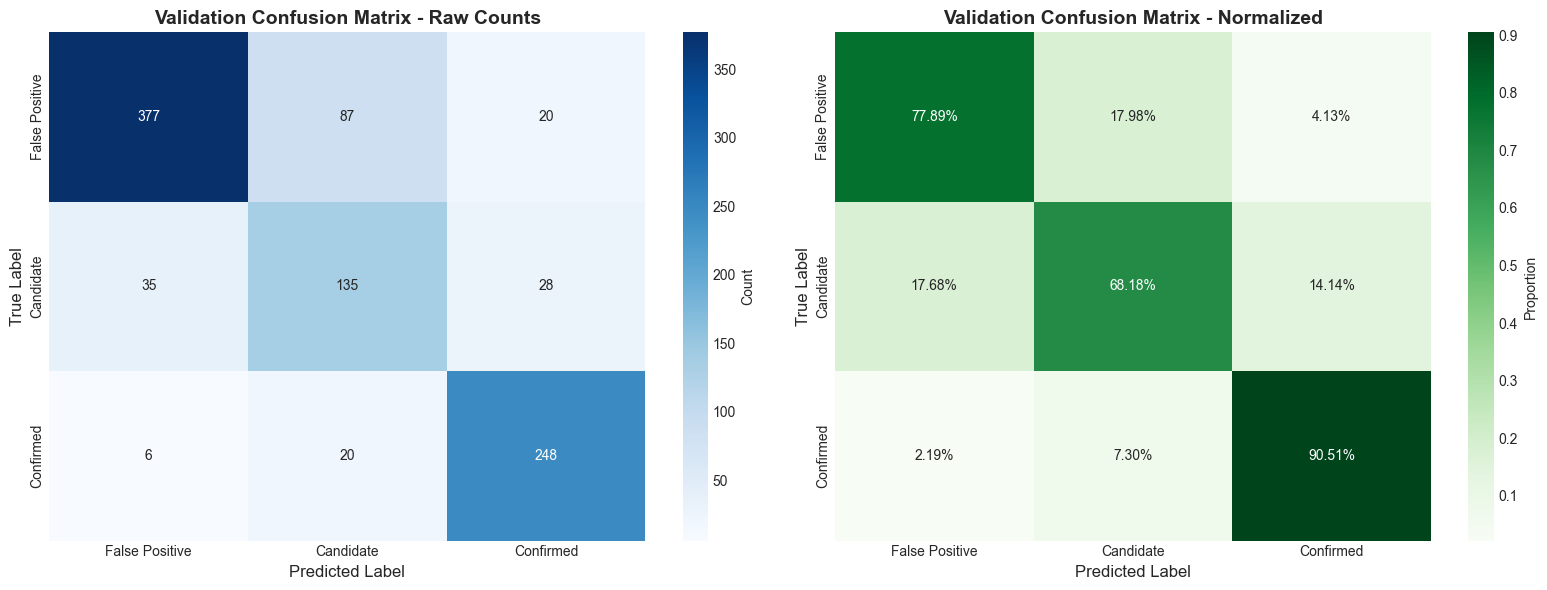

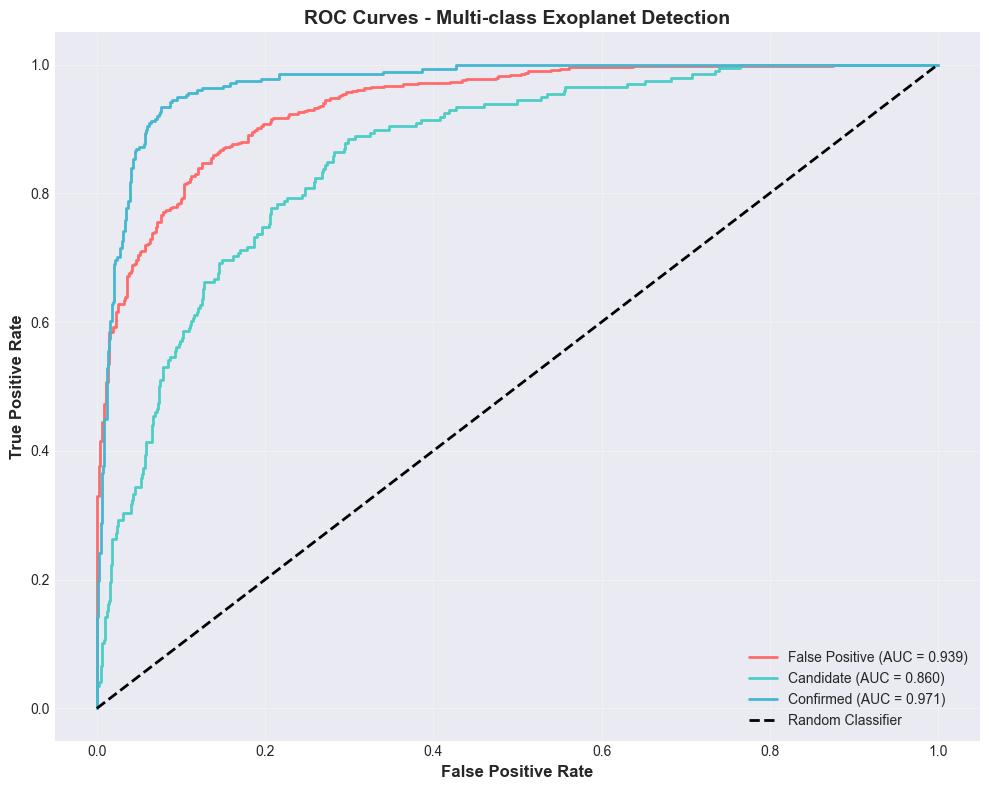

In [73]:
y_val_pred_proba = model.predict(X_validate_enhanced, num_iteration=model.best_iteration)
y_val_pred = y_val_pred_proba.argmax(axis=1)

val_accuracy = accuracy_score(y_validate, y_val_pred)
val_precision = precision_score(y_validate, y_val_pred, average='weighted')
val_recall = recall_score(y_validate, y_val_pred, average='weighted')
val_f1_macro = f1_score(y_validate, y_val_pred, average='macro')
val_f1_weighted = f1_score(y_validate, y_val_pred, average='weighted')

print("Overall Performance Metrics:")
print(f"   Accuracy:           {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print(f"   Precision (Avg):    {val_precision:.4f}")
print(f"   Recall (Avg):       {val_recall:.4f}")
print(f"   F1-Score (Macro):   {val_f1_macro:.4f}")
print(f"   F1-Score (Weighted):{val_f1_weighted:.4f}")

print("\n📋 Per-Class Performance:")
print(classification_report(
    y_validate, 
    y_val_pred,
    target_names=['False Positive', 'Candidate', 'Confirmed'],
    digits=4
))

# Confusion Matrix Visualization
cm = confusion_matrix(y_validate, y_val_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['False Positive', 'Candidate', 'Confirmed'],
            yticklabels=['False Positive', 'Candidate', 'Confirmed'],
            cbar_kws={'label': 'Count'})
ax1.set_title('Validation Confusion Matrix - Raw Counts', fontsize=14, fontweight='bold')
ax1.set_ylabel('True Label', fontsize=12)
ax1.set_xlabel('Predicted Label', fontsize=12)

# Normalized
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens', ax=ax2,
            xticklabels=['False Positive', 'Candidate', 'Confirmed'],
            yticklabels=['False Positive', 'Candidate', 'Confirmed'],
            cbar_kws={'label': 'Proportion'})
ax2.set_title('Validation Confusion Matrix - Normalized', fontsize=14, fontweight='bold')
ax2.set_ylabel('True Label', fontsize=12)
ax2.set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.savefig(f'./confusion_matrix_validation.png', 
            dpi=300, bbox_inches='tight')
plt.show()

# ROC Curve for multiclass
y_val_bin = label_binarize(y_validate, classes=[0, 1, 2])
fig, ax = plt.subplots(figsize=(10, 8))

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
for i, (color, name) in enumerate(zip(colors, ['False Positive', 'Candidate', 'Confirmed'])):
    fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_val_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color=color, lw=2, 
            label=f'{name} (AUC = {roc_auc:.3f})')

ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('ROC Curves - Multi-class Exoplanet Detection', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f'./roc_curves_validation.png', 
            dpi=300, bbox_inches='tight')
plt.show()


### TEST SET EVALUATION (FINAL)

🎯 Overall Performance Metrics:
   Accuracy:           0.7753 (77.53%)
   Precision (Avg):    0.7890
   Recall (Avg):       0.7753
   F1-Score (Macro):   0.7514
   F1-Score (Weighted):0.7800

📋 Detailed Classification Report:
                precision    recall  f1-score   support

False Positive     0.8650    0.7810    0.8208       484
     Candidate     0.5359    0.6414    0.5839       198
     Confirmed     0.8375    0.8618    0.8495       275

      accuracy                         0.7753       957
     macro avg     0.7461    0.7614    0.7514       957
  weighted avg     0.7890    0.7753    0.7800       957



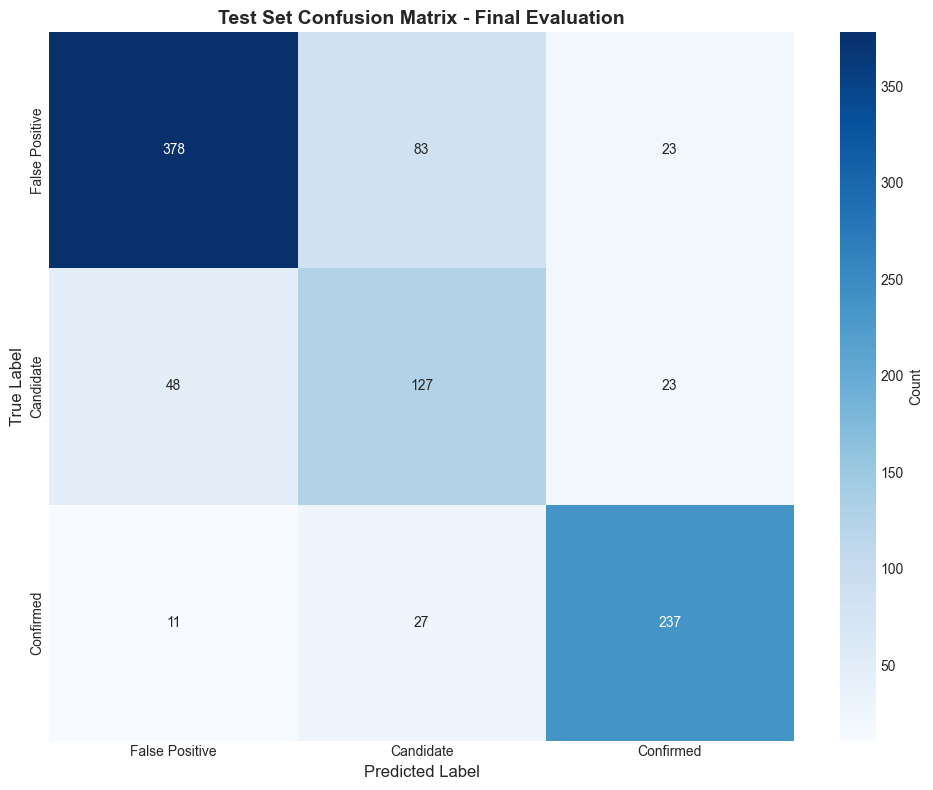

In [77]:
y_test_pred_proba = model.predict(X_test_enhanced, num_iteration=model.best_iteration)
y_test_pred = y_test_pred_proba.argmax(axis=1)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1_macro = f1_score(y_test, y_test_pred, average='macro')
test_f1_weighted = f1_score(y_test, y_test_pred, average='weighted')

print("🎯 Overall Performance Metrics:")
print(f"   Accuracy:           {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"   Precision (Avg):    {test_precision:.4f}")
print(f"   Recall (Avg):       {test_recall:.4f}")
print(f"   F1-Score (Macro):   {test_f1_macro:.4f}")
print(f"   F1-Score (Weighted):{test_f1_weighted:.4f}")

print("\n📋 Detailed Classification Report:")
print(classification_report(
    y_test, 
    y_test_pred,
    target_names=['False Positive', 'Candidate', 'Confirmed'],
    digits=4
))

# Test confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=['False Positive', 'Candidate', 'Confirmed'],
            yticklabels=['False Positive', 'Candidate', 'Confirmed'],
            cbar_kws={'label': 'Count'})
plt.title('Test Set Confusion Matrix - Final Evaluation', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig(f'./confusion_matrix_test.png', 
            dpi=300, bbox_inches='tight')
plt.show()

### SAVING MODEL & METADATA 

In [79]:
# Save model
model_path = f'./lgb_model_v1.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(model, f)
print(f"✅ Model saved: {model_path}")

# Save metadata
metadata = {
    'model_type': 'LightGBM Gradient Boosting',
    'version': '1.0',
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'dataset': {
        'train_samples': len(X_train),
        'val_samples': len(X_validate),
        'test_samples': len(X_test),
        'n_features': X_train_enhanced.shape[1],
        'class_distribution': y_train.value_counts().to_dict()
    },
    'performance': {
        'validation': {
            'accuracy': float(val_accuracy),
            'f1_macro': float(val_f1_macro),
            'f1_weighted': float(val_f1_weighted)
        },
        'test': {
            'accuracy': float(test_accuracy),
            'f1_macro': float(test_f1_macro),
            'f1_weighted': float(test_f1_weighted)
        }
    },
    'hyperparameters': lgb_params,
    'best_iteration': model.best_iteration,
    'top_features': feature_importance.head(10)['feature'].tolist(),
    'transit_features_used': transit_features
}

metadata_path = f'./model_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=4)
print(f"✅ Metadata saved: {metadata_path}")

# Save feature importance
feature_importance.to_csv(
    f'./feature_importance.csv', 
    index=False
)
print(f"✅ Feature importance saved")



print("📊 Summary:")
print(f"   Model:              LightGBM v{metadata['version']}")
print(f"   Test Accuracy:      {test_accuracy*100:.2f}%")
print(f"   F1-Score (Macro):   {test_f1_macro:.4f}")
print(f"   Training Time:      {model.best_iteration} iterations")
print(f"   Feature Space:      {X_train_enhanced.shape[1]} features")
print(f"\n   Ready for ensemble integration! 🚀")
print(f"   Next: XGBoost + CatBoost → Final ensemble")

✅ Model saved: ./lgb_model_v1.pkl
✅ Metadata saved: ./model_metadata.json
✅ Feature importance saved
📊 Summary:
   Model:              LightGBM v1.0
   Test Accuracy:      77.53%
   F1-Score (Macro):   0.7514
   Training Time:      264 iterations
   Feature Space:      18 features

   Ready for ensemble integration! 🚀
   Next: XGBoost + CatBoost → Final ensemble
